In [1]:
#imports
import pandas as pd
import os
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms,models
from torchvision.io import read_image
import torch.nn.functional as F 
from torchvision.utils import make_grid
#from torchvision.ops import stochastic_depth

import timm
from timm.loss import LabelSmoothingCrossEntropy

print(torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


2.1.2
cuda:0


# **Loading the dataset**

In [2]:
path = "/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2"


data = {"imagepath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imagepath"].append(fpath)
        data["labels"].append(folder)
        
    df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])


print("-------------Fetch files into a data frame-----------")
print(df)
print("-------------Path to an image file------------------")
print(df.loc[175]['imagepath']) 
print("-----------Number of images per category--------------")
print(df.labels.value_counts())  

-------------Fetch files into a data frame-----------
                                              imagepath labels  encoded_labels
0     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
1     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
2     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
3     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
4     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
...                                                 ...    ...             ...
6980  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6981  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6982  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6983  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6984  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              1

# **Displaying Histogram of the dataset**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


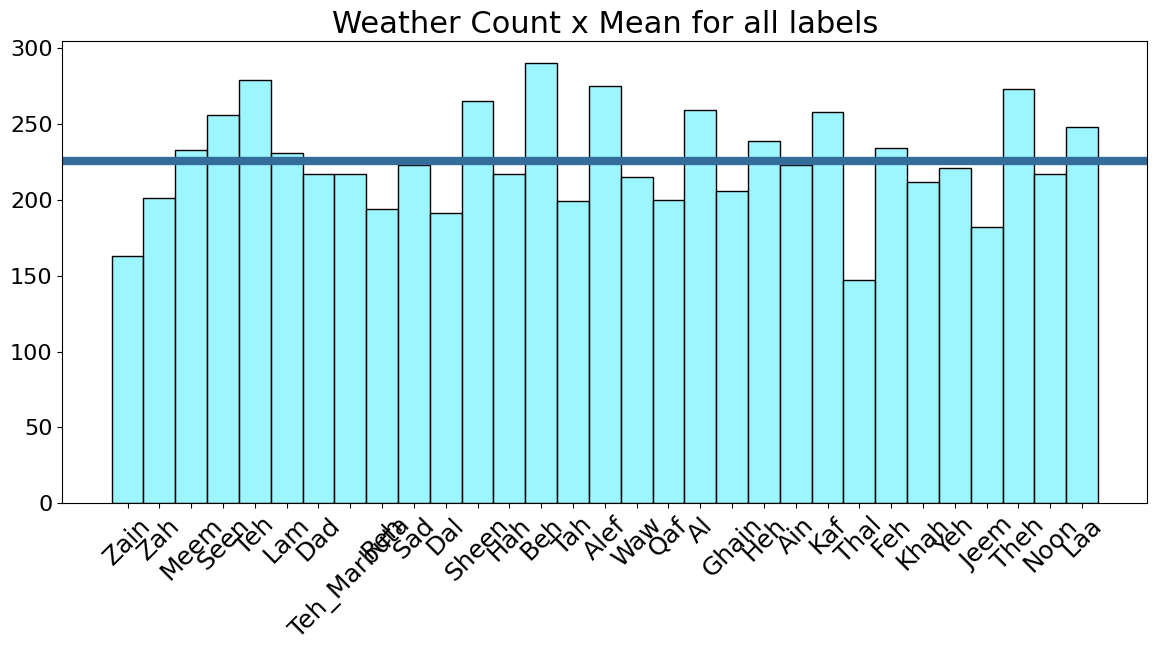

In [3]:
ax = sns.histplot(data=df, x="labels", color="#7df2ff")
ax.figure.set_size_inches(14, 6)
plt.axhline(y=df.groupby("labels").count().mean().mean(), lw=6, color="#346c9a")
plt.xticks(rotation=45, font="Verdana", fontsize=18)
plt.yticks(font="Verdana", fontsize=16)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Weather Count x Mean for all labels", font="Verdana", fontsize=22)

plt.show()

# **Splitting into train,val and test sets** 

In [4]:
train_df, temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124, stratify = df.labels)
valid_df , test_df = train_test_split(temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imagepath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imagepath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imagepath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                           imagepath labels
0  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Ain
1  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Tah
2  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Sad
3  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Jeem
4  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Dad
(4889, 3)
--------Validation----------
                                           imagepath labels
0  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa
1  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Khah
2  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Khah
3  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Seen
4  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Lam
(1467, 3)
----------Test--------------
                                           imagepath labels
0  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...     Al
1  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba... 

# **Displaying random images**

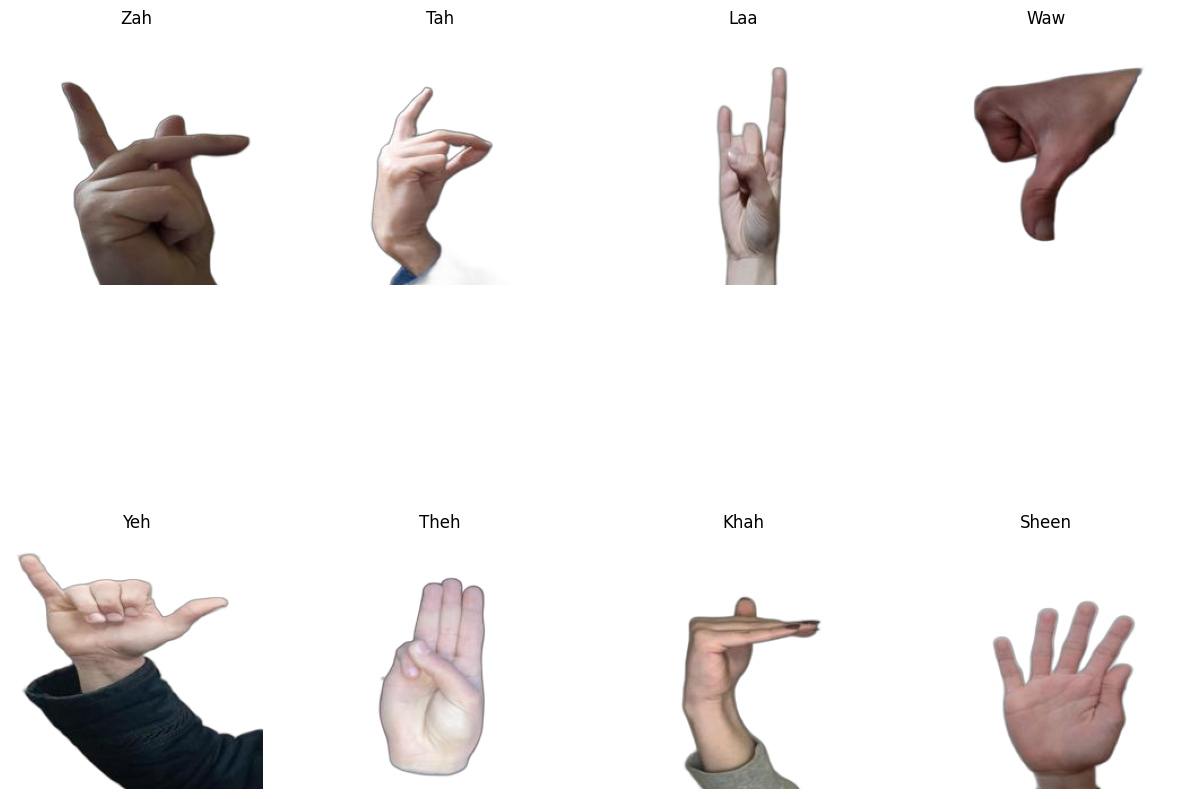

In [5]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=8).reset_index().iterrows():
    plt.subplot(2,4,i+1)
    image_path = row['imagepath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

# **Data Augmentation**

In [6]:

train_transforms = transforms.Compose([
    #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# **Displaying random sample and the augmented image**

In [7]:
#Load & View Random Sample Image
def load(imagepath, as_tensor=True):
    # Read and decode an image file to a uint8 tensor
    image = Image.open(imagepath).convert('RGB')
    
    if as_tensor:
        converter = transforms.ToTensor()
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
    
    plt.title(f'Label: {label}', fontsize=16)
    return

In [8]:
# Select random sample from df
import random
idx = random.sample(df.index.to_list(), 1)[0]

# Load the random sample and label
aug_image = load(df.imagepath[idx], as_tensor=False)

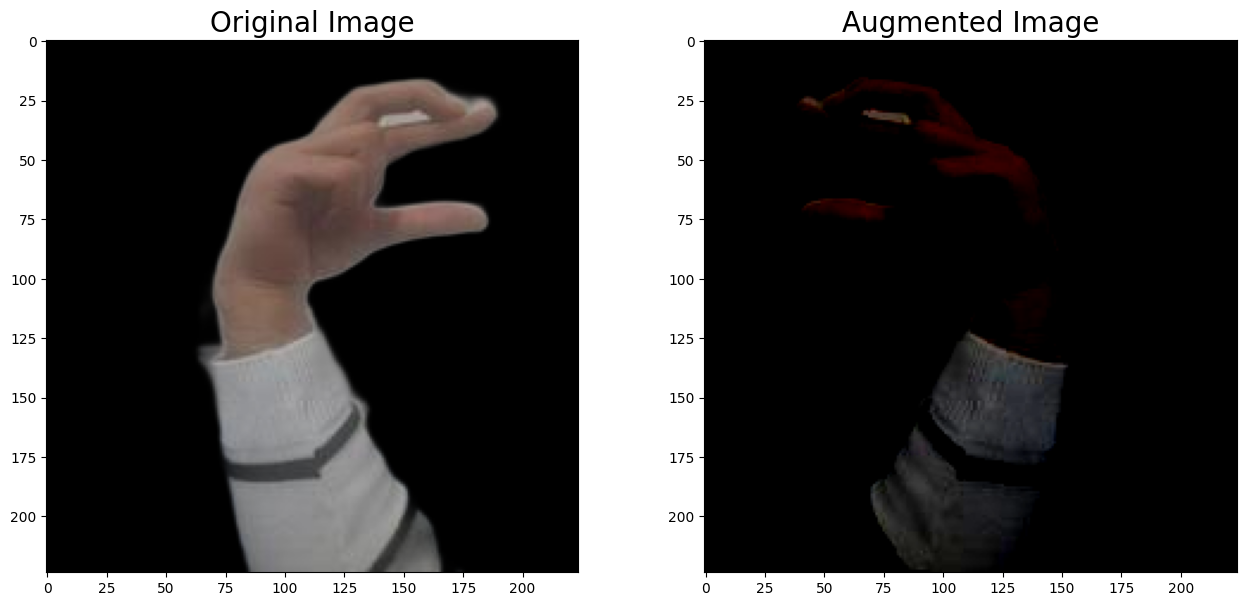

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(aug_image);

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(train_transforms(aug_image).permute(1, 2, 0));

# **Building datasets based on splits**

In [10]:
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

In [11]:
class ArSL_Dataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
        
        self.paths = df['imagepath'].to_list()
        self.labels = df['labels'].to_list()
        self.transform = transform
        
        self.classes = sorted(list(df['labels'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        
    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')  
        
    def __len__(self) -> int:
        return self.paths.__len__()
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

In [12]:
# Build train dataset
train_ds = ArSL_Dataset(train_df, transform=train_transforms)

# Build validation dataset
valid_ds = ArSL_Dataset(valid_df, transform=test_transforms)

# Build test dataset
test_ds = ArSL_Dataset(test_df, transform=test_transforms)

In [13]:
BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size = BATCH_SIZE, shuffle= False)
test_dataloader = DataLoader(test_ds, batch_size= BATCH_SIZE , shuffle=False)

print(">> Number of Train Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(train_dataloader.dataset) , BATCH_SIZE , len(train_dataloader)))
print(">> Number of Valid Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(valid_dataloader.dataset) , BATCH_SIZE , len(valid_dataloader)))
print(">> Number of  Test Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(test_dataloader.dataset) , BATCH_SIZE , len(test_dataloader)))
onebatch = iter(train_dataloader)
train_features, train_labels = next(onebatch)
print("----------Batch Shape--------")
print(f"Feature batch shape: {train_features.size()}")
print("----------Labels Shape--------")
print(f"Labels batch shape: {train_labels.size()}")

>> Number of Train Data : 4889 -- Batch Size : 64 -- Number of Batch : 77 
>> Number of Valid Data : 1467 -- Batch Size : 64 -- Number of Batch : 23 
>> Number of  Test Data : 629 -- Batch Size : 64 -- Number of Batch : 10 
----------Batch Shape--------
Feature batch shape: torch.Size([64, 3, 224, 224])
----------Labels Shape--------
Labels batch shape: torch.Size([64])


# **KANLinear**

In [14]:
# Define the KANLinear class as provided
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=10, spline_order=3, scale_noise=0.05, scale_base=0.5, scale_spline=0.5, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy
     

# **Model Architecture**

In [15]:
class CustomResNetKAN(nn.Module):
    def __init__(self, num_classes=31):
        super(CustomResNetKAN, self).__init__()
        # Load DenseNet121
        self.model = models.densenet121(pretrained=True)
        # Replace classifier with KANLinear
        self.model.classifier = KANLinear(self.model.classifier.in_features, out_features=num_classes)

    def forward(self, x):
        return self.model(x)

In [16]:
#model = resnext50(num_classes = 31)
#model = model.to(device)
model = CustomResNetKAN().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 145MB/s]


# **Hyperparameters**

In [17]:
# Define Loss Function
loss_fn = LabelSmoothingCrossEntropy()

# Define Optimizer
optimizer = optim.Adam(model.parameters(),lr= 0.001)



# **Train Function**

In [18]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into training mode
    model.train()
    
    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0
    
    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)
        
        # Feed-forward and compute metrics
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        
        # Update Model Gradients
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

# **Evaluation Function**

In [19]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into eval mode
    model.eval()
    
    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item() 

            # Compute Batch Metrics
            predicted_class = torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    return eval_loss, eval_acc

In [20]:
import torch
from typing import Dict, List
from tqdm import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    eval_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    patience: int = 5,  # Early stopping patience
) -> Dict[str, List]:
    # Initialize training session metrics
    session = {
        'loss': [],
        'accuracy': [],
        'eval_loss': [],
        'eval_accuracy': []
    }

    best_eval_loss = float('inf')  # Initialize the best evaluation loss
    patience_counter = 0  # Counter for early stopping
    best_model_weights = model.state_dict()  # Save initial weights

    for epoch in tqdm(range(epochs)):
        print(f'\nEpoch {epoch + 1}/{epochs}')

        # Training step
        train_loss, train_acc = execute_epoch(
            model, train_dataloader, optimizer, loss_fn, device
        )

        # Evaluation step
        eval_loss, eval_acc = evaluate(model, eval_dataloader, loss_fn, device)

        # Logging
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')

        # Record metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuracy'].append(eval_acc)

        # Early stopping logic
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            best_model_weights = model.state_dict()  # Save the best model weights
            patience_counter = 0  # Reset patience counter
            print("Validation loss improved. Best model saved.")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

        # Stop training if patience exceeded
            if patience_counter >= patience:
                print("Early stopping triggered. Restoring best model weights.")
                model.load_state_dict(best_model_weights)  # Restore best weights
                break

    # Return training session metrics
    return session


In [21]:
# Train the model 
print(f'Train on {len(train_df)} samples, validate on {len(valid_df)} samples.')
print('----------------------------------')

session_config = {
    'model'               : model,
    'train_dataloader'    : train_dataloader,
    'eval_dataloader'     : valid_dataloader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : 50,
    'device'              : device
}

session_history = train(**session_config)

Train on 4889 samples, validate on 1467 samples.
----------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50



  2%|▏         | 1/50 [02:08<1:44:46, 128.30s/it]

loss: 1.4530 - acc: 0.7344 - eval_loss: 1.1344 - eval_acc: 0.8295
Validation loss improved. Best model saved.

Epoch 2/50



  4%|▍         | 2/50 [03:22<1:17:19, 96.65s/it] 

loss: 0.9036 - acc: 0.9278 - eval_loss: 0.9115 - eval_acc: 0.9201
Validation loss improved. Best model saved.

Epoch 3/50



  6%|▌         | 3/50 [04:36<1:07:31, 86.21s/it]

loss: 0.8481 - acc: 0.9456 - eval_loss: 0.8793 - eval_acc: 0.9420
Validation loss improved. Best model saved.

Epoch 4/50



  8%|▊         | 4/50 [05:50<1:02:25, 81.41s/it]

loss: 0.8083 - acc: 0.9597 - eval_loss: 0.8082 - eval_acc: 0.9577
Validation loss improved. Best model saved.

Epoch 5/50



 10%|█         | 5/50 [07:05<59:21, 79.14s/it]  

loss: 0.7707 - acc: 0.9718 - eval_loss: 0.8233 - eval_acc: 0.9426
Validation loss did not improve. Patience counter: 1/5

Epoch 6/50



 12%|█▏        | 6/50 [08:20<57:00, 77.74s/it]

loss: 0.7520 - acc: 0.9756 - eval_loss: 0.8033 - eval_acc: 0.9564
Validation loss improved. Best model saved.

Epoch 7/50



 14%|█▍        | 7/50 [09:34<54:48, 76.48s/it]

loss: 0.7319 - acc: 0.9834 - eval_loss: 0.7524 - eval_acc: 0.9700
Validation loss improved. Best model saved.

Epoch 8/50



 16%|█▌        | 8/50 [10:48<52:56, 75.62s/it]

loss: 0.7427 - acc: 0.9782 - eval_loss: 0.7822 - eval_acc: 0.9610
Validation loss did not improve. Patience counter: 1/5

Epoch 9/50



 18%|█▊        | 9/50 [12:02<51:16, 75.04s/it]

loss: 0.7378 - acc: 0.9747 - eval_loss: 0.7451 - eval_acc: 0.9714
Validation loss improved. Best model saved.

Epoch 10/50



 20%|██        | 10/50 [13:16<49:49, 74.73s/it]

loss: 0.7226 - acc: 0.9827 - eval_loss: 0.7833 - eval_acc: 0.9632
Validation loss did not improve. Patience counter: 1/5

Epoch 11/50



 22%|██▏       | 11/50 [14:30<48:29, 74.60s/it]

loss: 0.7157 - acc: 0.9886 - eval_loss: 0.7426 - eval_acc: 0.9721
Validation loss improved. Best model saved.

Epoch 12/50



 24%|██▍       | 12/50 [15:44<47:06, 74.39s/it]

loss: 0.6986 - acc: 0.9903 - eval_loss: 0.7482 - eval_acc: 0.9707
Validation loss did not improve. Patience counter: 1/5

Epoch 13/50



 26%|██▌       | 13/50 [16:58<45:48, 74.29s/it]

loss: 0.6992 - acc: 0.9884 - eval_loss: 0.7297 - eval_acc: 0.9762
Validation loss improved. Best model saved.

Epoch 14/50



 28%|██▊       | 14/50 [18:12<44:35, 74.31s/it]

loss: 0.6999 - acc: 0.9874 - eval_loss: 0.7278 - eval_acc: 0.9783
Validation loss improved. Best model saved.

Epoch 15/50



 30%|███       | 15/50 [19:26<43:18, 74.24s/it]

loss: 0.6929 - acc: 0.9892 - eval_loss: 0.7469 - eval_acc: 0.9741
Validation loss did not improve. Patience counter: 1/5

Epoch 16/50



 32%|███▏      | 16/50 [20:41<42:05, 74.27s/it]

loss: 0.6852 - acc: 0.9935 - eval_loss: 0.7036 - eval_acc: 0.9836
Validation loss improved. Best model saved.

Epoch 17/50



 34%|███▍      | 17/50 [21:55<40:51, 74.28s/it]

loss: 0.6844 - acc: 0.9917 - eval_loss: 0.7204 - eval_acc: 0.9796
Validation loss did not improve. Patience counter: 1/5

Epoch 18/50



 36%|███▌      | 18/50 [23:09<39:33, 74.18s/it]

loss: 0.6901 - acc: 0.9908 - eval_loss: 0.7497 - eval_acc: 0.9679
Validation loss did not improve. Patience counter: 2/5

Epoch 19/50



 38%|███▊      | 19/50 [24:23<38:17, 74.13s/it]

loss: 0.7191 - acc: 0.9832 - eval_loss: 0.7700 - eval_acc: 0.9536
Validation loss did not improve. Patience counter: 3/5

Epoch 20/50



 40%|████      | 20/50 [25:37<37:04, 74.15s/it]

loss: 0.6876 - acc: 0.9931 - eval_loss: 0.7199 - eval_acc: 0.9794
Validation loss did not improve. Patience counter: 4/5

Epoch 21/50



 40%|████      | 20/50 [26:51<40:17, 80.58s/it]

loss: 0.7029 - acc: 0.9846 - eval_loss: 0.7309 - eval_acc: 0.9715
Validation loss did not improve. Patience counter: 5/5
Early stopping triggered. Restoring best model weights.


In [22]:
# lr scheduler
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

# **Inference**

In [23]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
    # Set model into eval mode
    model.eval()
    
    predictions = []
    
    # Active inference context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X) 

            # Compute Batch Metrics
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            
            # Record prediction
            predictions.append(predicted_probs)
        
    return np.vstack(predictions)

In [24]:
# Generate test sample probabilities 
test_probs = predict(model, test_dataloader, device)

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


In [25]:
# Generate test sample preditions 
test_preds = np.argmax(test_probs, axis=1)

# **Plot Model Performance**

In [26]:
def plot_training_curves(history):
    
    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['eval_accuracy'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='validation_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();
    
    return

In [27]:
session_history_df = pd.DataFrame(session_history)
session_history_df

loss  accuracy  eval_loss  eval_accuracy
0   1.452973  0.734351   1.134396       0.829530
1   0.903586  0.927760   0.911526       0.920056
2   0.848061  0.945593   0.879296       0.941968
3   0.808317  0.959683   0.808220       0.957708
4   0.770667  0.971794   0.823328       0.942589
5   0.751953  0.975649   0.803295       0.956407
6   0.731880  0.983450   0.752354       0.969994
7   0.742731  0.978174   0.782211       0.961047
8   0.737833  0.974700   0.745115       0.971352
9   0.722556  0.982727   0.783281       0.963200
10  0.715733  0.988636   0.742647       0.972147
11  0.698584  0.990260   0.748203       0.970673
12  0.699238  0.988433   0.729704       0.976165
13  0.699899  0.987419   0.727785       0.978261
14  0.692920  0.989245   0.746888       0.974070
15  0.685152  0.993506   0.703557       0.983638
16  0.684401  0.991680   0.720381       0.979562
17  0.690075  0.990755   0.749721       0.967898
18  0.719129  0.983247   0.769956       0.953574
19  0.687577  0.993101   0.719867       0.979447
20  0.702888  0.984578   0.730863       0.971467

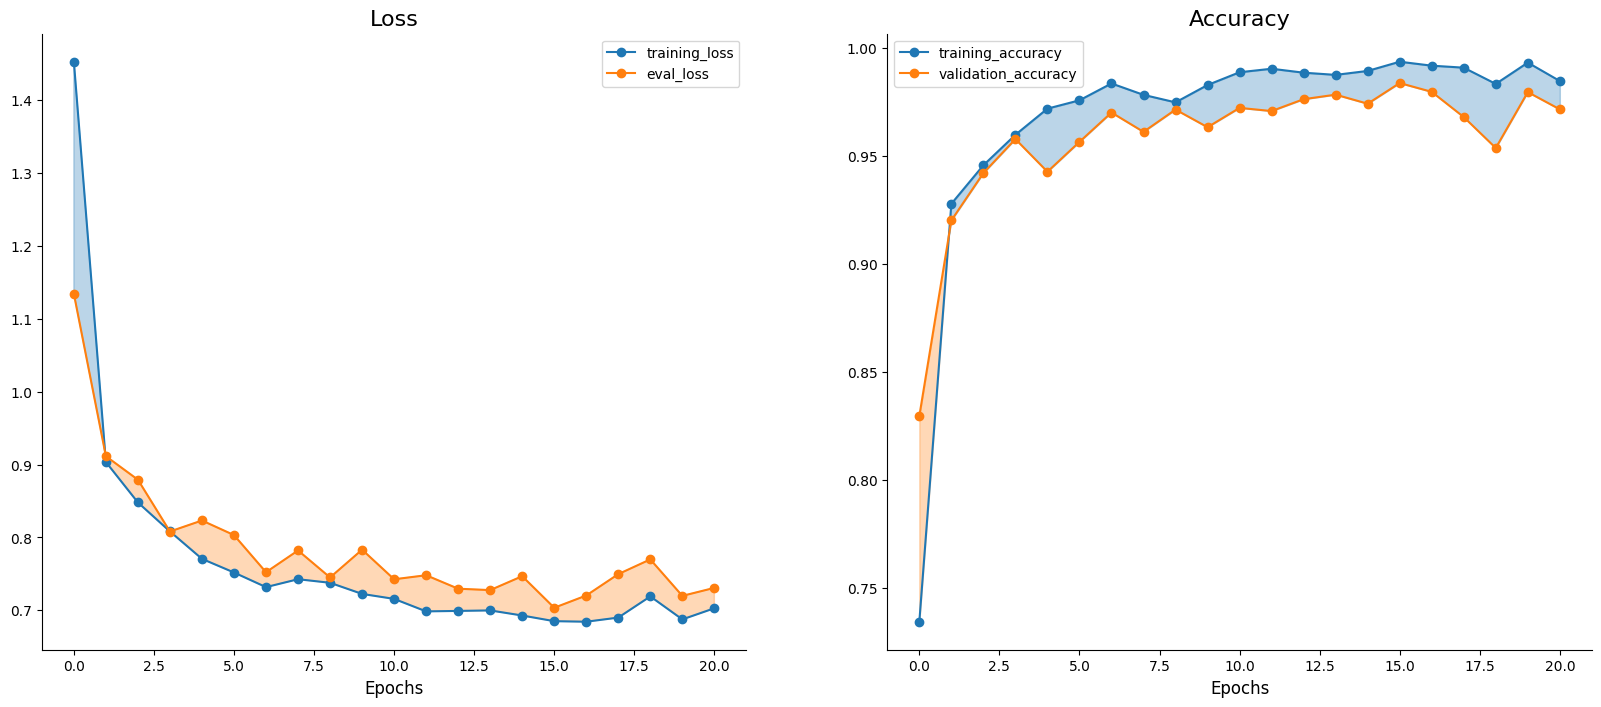

In [28]:
plot_training_curves(session_history)

# **Performance Metrics**

In [29]:
#imports
from scikitplot.metrics import plot_roc
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score, 
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)

**Confusion Matrix**

In [30]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

In [31]:
#mapping
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

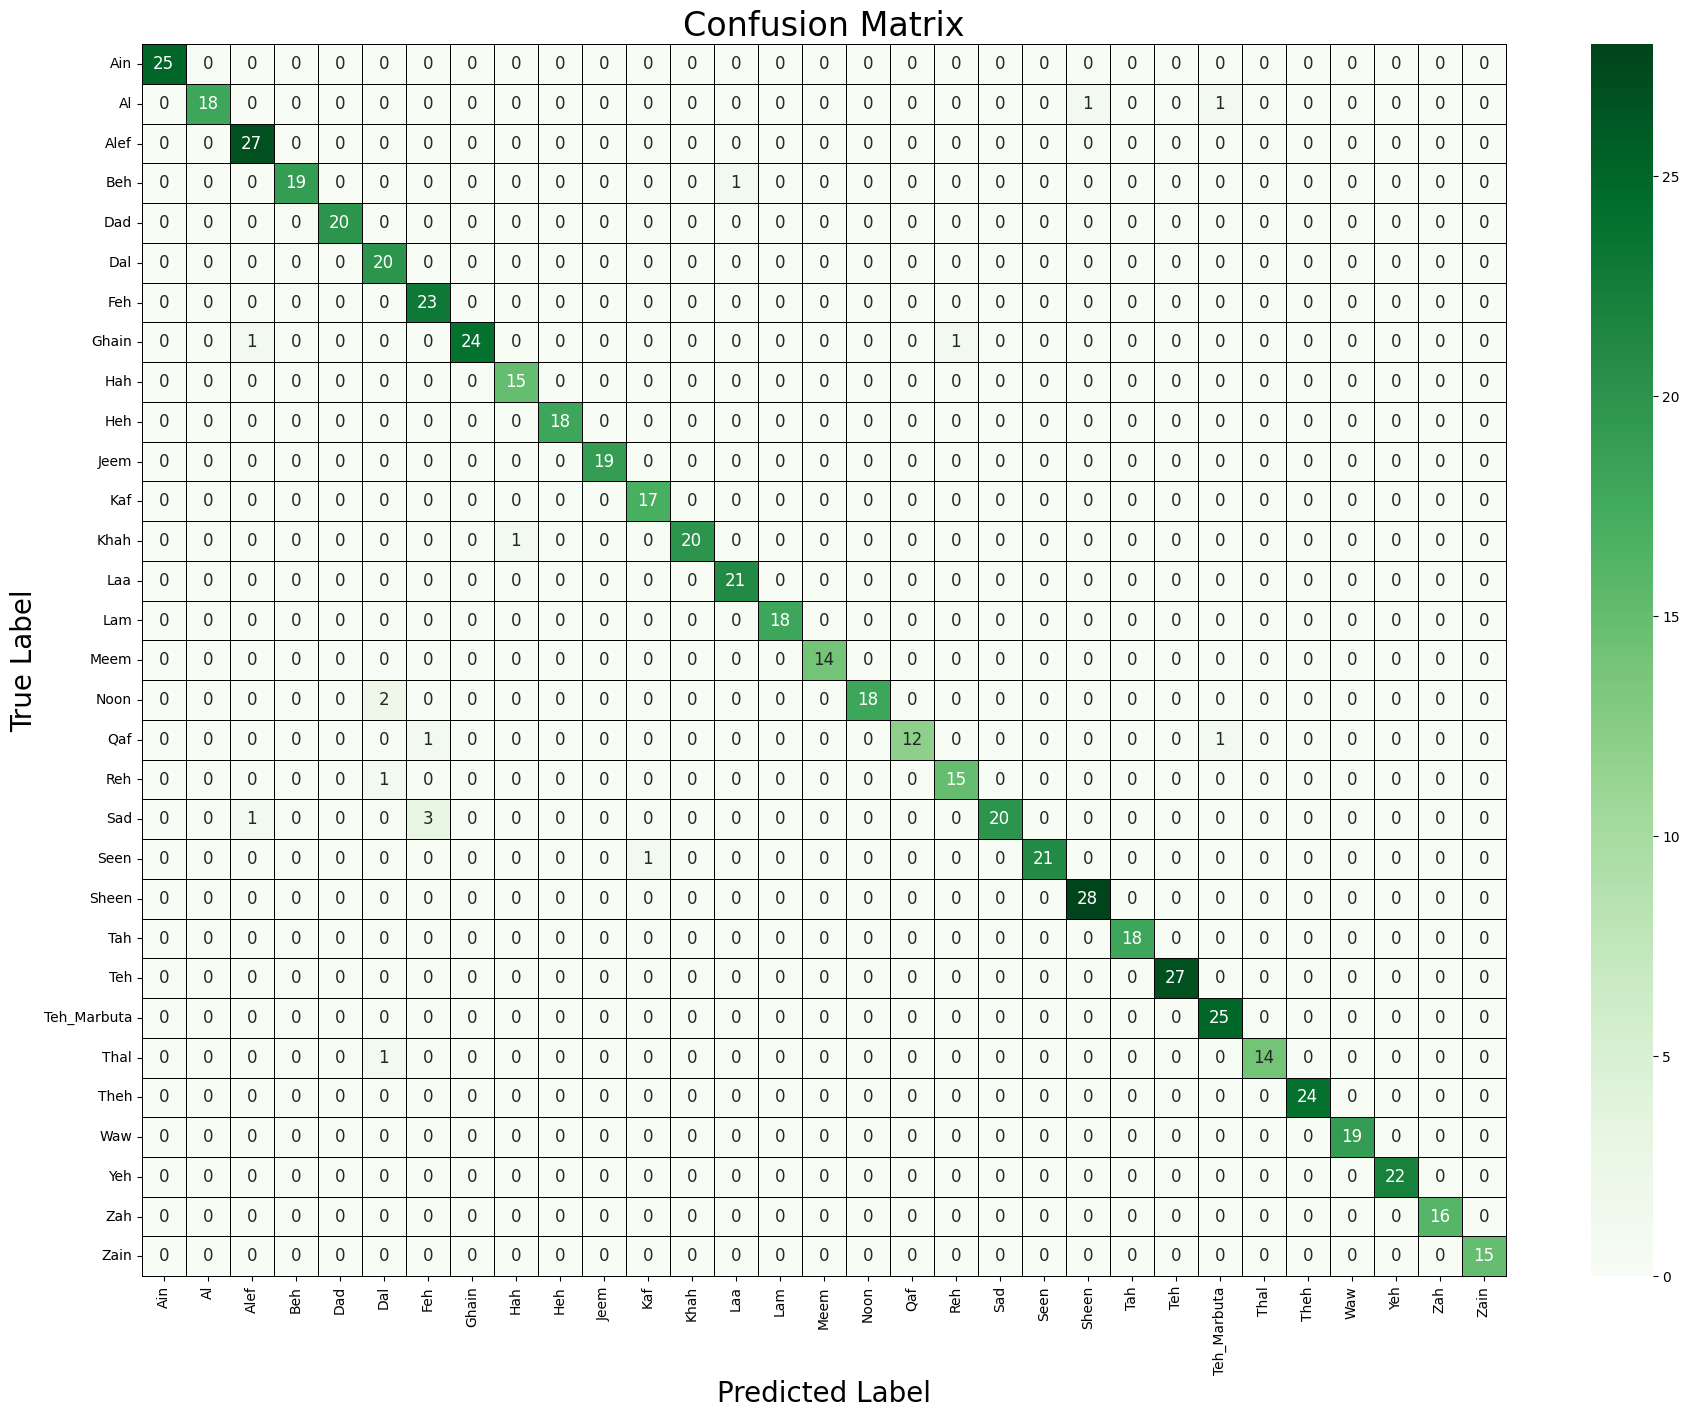

In [32]:
plot_confusion_matrix(
    test_labels, 
    test_preds, 
    figsize=(22, 16),  
    classes=test_ds.classes)

**Classification Report**

In [33]:
print(
    classification_report(
        test_labels, 
        test_preds, 
        target_names=test_ds.classes
    )
)

              precision    recall  f1-score   support

         Ain       1.00      1.00      1.00        25
          Al       1.00      0.90      0.95        20
        Alef       0.93      1.00      0.96        27
         Beh       1.00      0.95      0.97        20
         Dad       1.00      1.00      1.00        20
         Dal       0.83      1.00      0.91        20
         Feh       0.85      1.00      0.92        23
       Ghain       1.00      0.92      0.96        26
         Hah       0.94      1.00      0.97        15
         Heh       1.00      1.00      1.00        18
        Jeem       1.00      1.00      1.00        19
         Kaf       0.94      1.00      0.97        17
        Khah       1.00      0.95      0.98        21
         Laa       0.95      1.00      0.98        21
         Lam       1.00      1.00      1.00        18
        Meem       1.00      1.00      1.00        14
        Noon       1.00      0.90      0.95        20
         Qaf       1.00    

In [34]:
 report = classification_report(
        test_labels, 
        test_preds, 
        target_names=test_ds.classes,
        output_dict=True
    )

In [35]:
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report.to_csv('DenseNet-KAN classification_report.csv', index=True)

In [36]:
def generate_performance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    top_3_accuracy = top_k_accuracy_score(
        y_true, y_probabilities, k=3
    )
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
    )    
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'top_3_accuracy'       : top_3_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [37]:
model_performance = generate_performance_scores(
    test_labels,
    test_preds, 
    test_probs
)


Performance Metrics:

accuracy_score:		0.9730

_____________________________________________
top_3_accuracy_score:	0.9968

_____________________________________________
precision_score:	0.9757

_____________________________________________
recall_score:		0.9730

_____________________________________________
f1_score:		0.9730

_____________________________________________
matthews_corrcoef:	0.9721



**ROC Score**

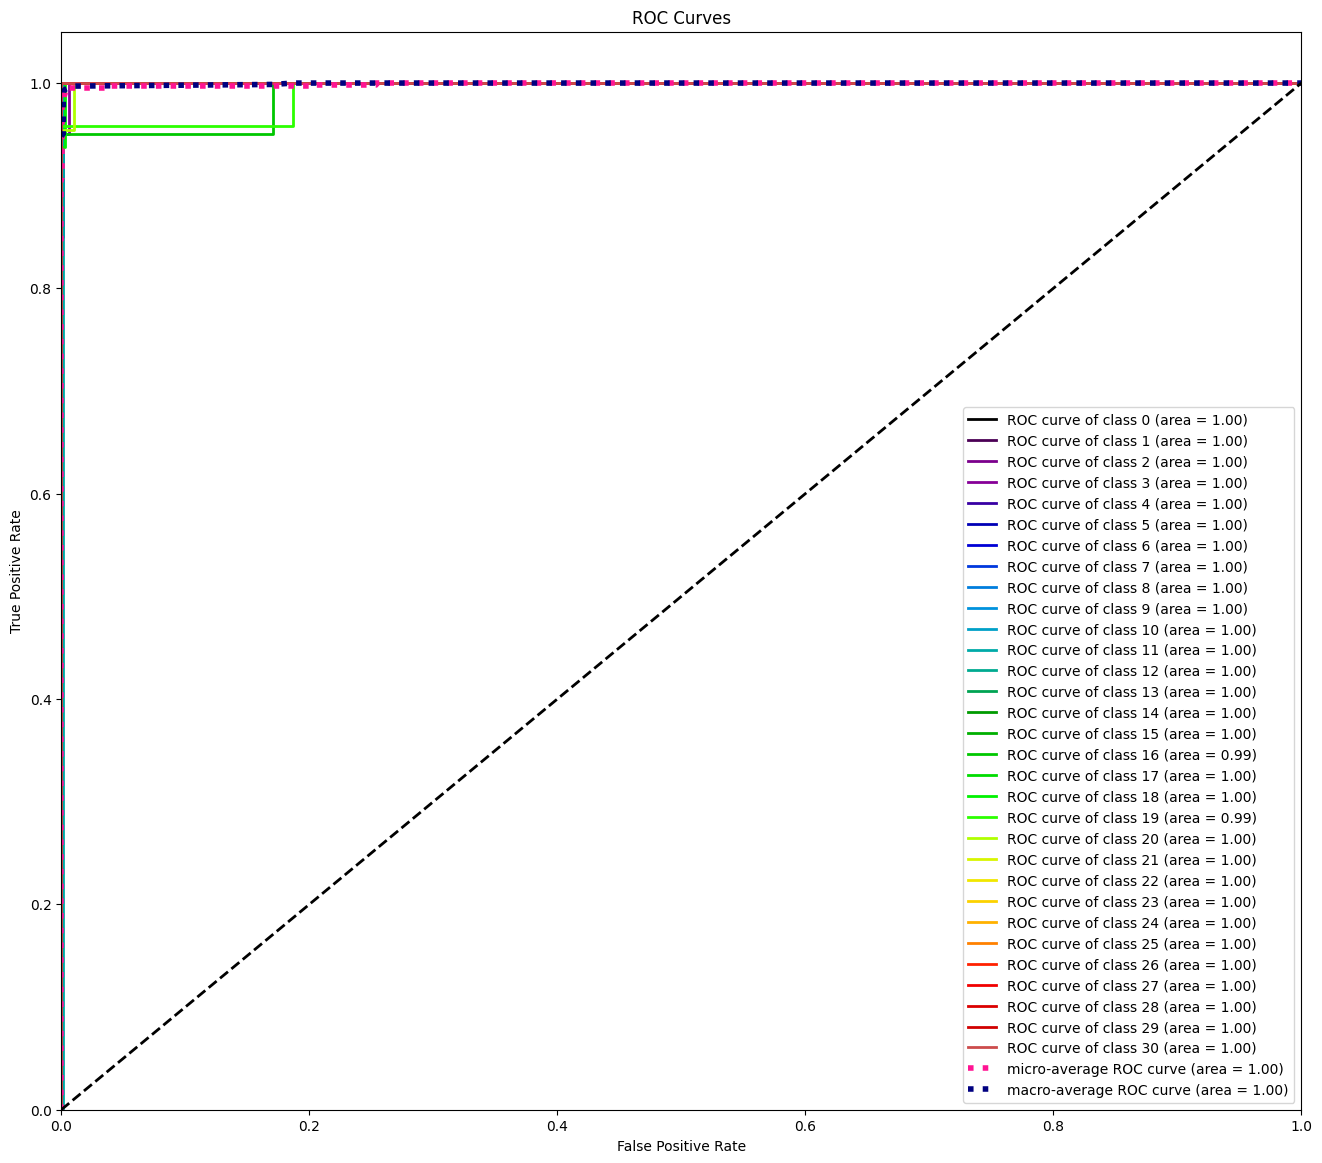

In [38]:
plot_roc(
    test_labels, 
    test_probs, 
    figsize=(16, 14), title_fontsize='large'
);

# **Performance Analysis**

**Probabilities and Predictions**

In [39]:
results_df = pd.DataFrame({
    'image_path'       : test_ds.paths,
    'label'            : test_ds.labels,
    'label_encoded'    : test_labels,
    'model_prediction' : test_preds,
    'model_probability': [test_probs[_][pred] for _, pred in zip(range(len(test_probs)), test_preds)]
})

pd.set_option('display.max_colwidth', None)
results_df

image_path  \
0                       /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Al/Al_14.jpg   
1                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Jeem/Jeem_114.jpg   
2                    /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Beh/Beh_32.jpeg   
3                    /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dad/Dad_209.jpg   
4                /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Ghain/Ghain_57.jpeg   
..                                                                                         ...   
624                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Laa/Laa_211.jpg   
625              /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Sheen/Sheen_255.jpg   
626  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Teh_Marbuta/Teh_Marbuta_252.jpg   
627                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Heh/Heh_192.jpg   
628                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_127.jpg   

           label  label_encoded  model_prediction  model_probability  
0             Al              1                 1           0.833230  
1           Jeem             10                10           0.886240  
2            Beh              3                 3           0.869875  
3            Dad              4                 4           0.942787  
4          Ghain              7                 7           0.897309  
..           ...            ...               ...                ...  
624          Laa             13                13           0.907310  
625        Sheen             21                21           0.920436  
626  Teh_Marbuta             24                24           0.967764  
627          Heh              9                 9           0.890578  
628          Dal              5                 5           0.982699  

[629 rows x 5 columns]

In [40]:
def view_multiple_predictions(df, classes, sample_loader, count=10, color_map='rgb', title=None, fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)
    
    fig = plt.figure(figsize=fig_size)
    if title != None:
        fig.suptitle(title, fontsize=30)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    # Setup useful dictionaries
    label_set = {k: v for k, v in enumerate(classes)}
    color_set = {False: 'red', True: 'darkgreen'}
    
    for column, _ in enumerate(idx):
        # Predict label
        img = sample_loader(df.image_path[_]).permute(1, 2, 0)
        
        # Validate prediction correctness
        correct_prediction = (df.model_prediction[_] == df.label_encoded[_])
        
        # Create subplot and assign title
        ax = plt.subplot(rows, 5, column+1)
        ax.set_title(
            f'Actual Label: {df.label[_]}', 
            pad=20, 
            fontsize=14,
            color=color_set[correct_prediction]
        )
        
        # Plot image
        if color_map=='rgb':
            ax.imshow(img)
        else:
            ax.imshow(img, cmap=color_map)
        
        # Plot prediction  & probability
        txt = f'Prediction: {label_set[df.model_prediction[_]]}\nProbability: {(100 * df.model_probability[_]):.2f}%'
        plt.xlabel(txt, fontsize=14, color=color_set[correct_prediction])
        
    return

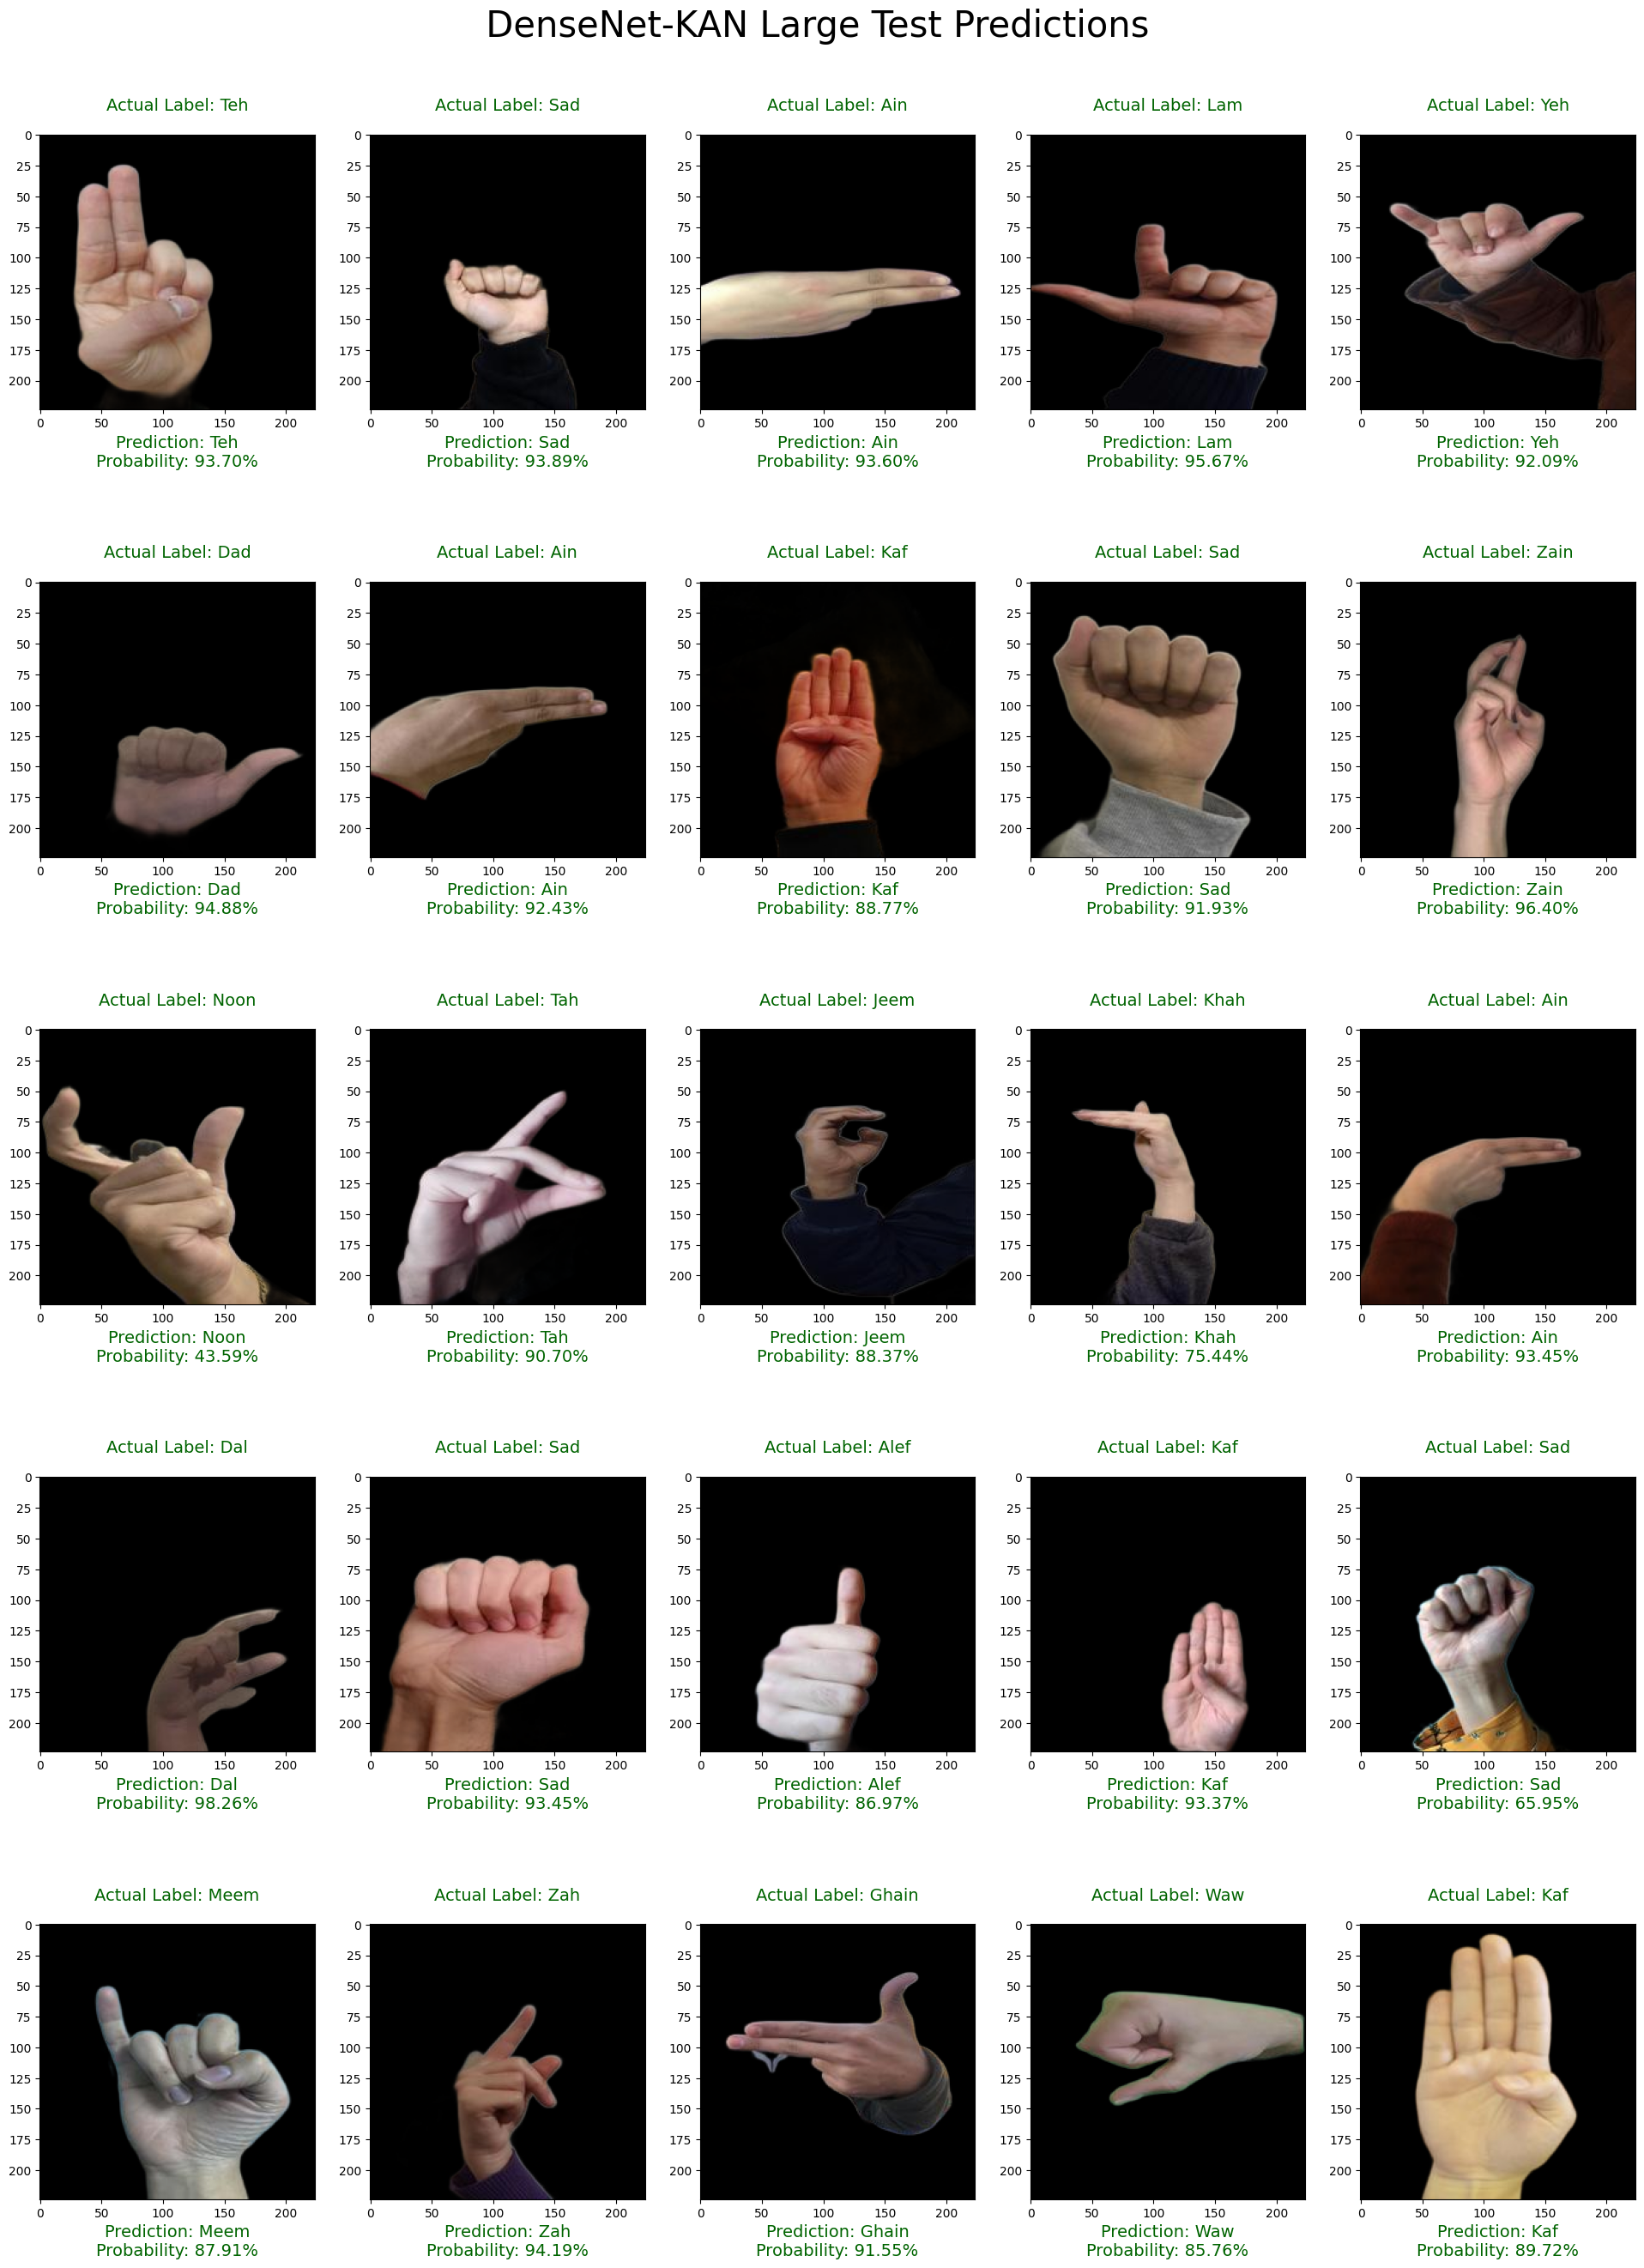

In [41]:
view_multiple_predictions(
    results_df,
    test_ds.classes,
    load, 
    count=25, 
    color_map='rgb', 
    title=' DenseNet-KAN Large Test Predictions',
    fig_size=(24, 30)
)

**Incorrect Predictions**

In [42]:
# Query incorrect predictions
query_df = results_df[
    results_df['label_encoded'] != results_df['model_prediction']
].reset_index(drop=True)

# View incorrect predictions
query_df

image_path  \
0      /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Khah/Khah_35.jpg   
1        /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Al/Al_263.jpeg   
2        /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Beh/Beh_25.jpg   
3      /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Noon/Noon_11.jpg   
4       /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Reh/Reh_170.jpg   
5   /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Ghain/Ghain_196.jpg   
6     /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Seen/Seen_103.jpg   
7       /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Qaf/Qaf_184.jpg   
8         /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Al/Al_128.jpg   
9       /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Sad/Sad_176.jpg   
10      /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Sad/Sad_113.jpg   
11      /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Sad/Sad_55.jpeg   
12    /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Thal/thal_198.jpg   
13      /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Qaf/Qaf_140.jpg   
14    /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Noon/Noon_221.jpg   
15      /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Sad/Sad_107.jpg   
16  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Ghain/Ghain_189.jpg   

    label  label_encoded  model_prediction  model_probability  
0    Khah             12                 8           0.430933  
1      Al              1                24           0.763440  
2     Beh              3                13           0.607617  
3    Noon             16                 5           0.686602  
4     Reh             18                 5           0.778437  
5   Ghain              7                 2           0.228913  
6    Seen             20                11           0.936983  
7     Qaf             17                24           0.447277  
8      Al              1                21           0.451496  
9     Sad             19                 6           0.414553  
10    Sad             19                 6           0.430643  
11    Sad             19                 2           0.374460  
12   Thal             25                 5           0.327957  
13    Qaf             17                 6           0.570355  
14   Noon             16                 5           0.961671  
15    Sad             19                 6           0.821008  
16  Ghain              7                18           0.309869

In [43]:
# Save incorrect predictions info in csv file
query_df.to_csv('DenseNet-KAN incorrect_predictions.csv', index=True)

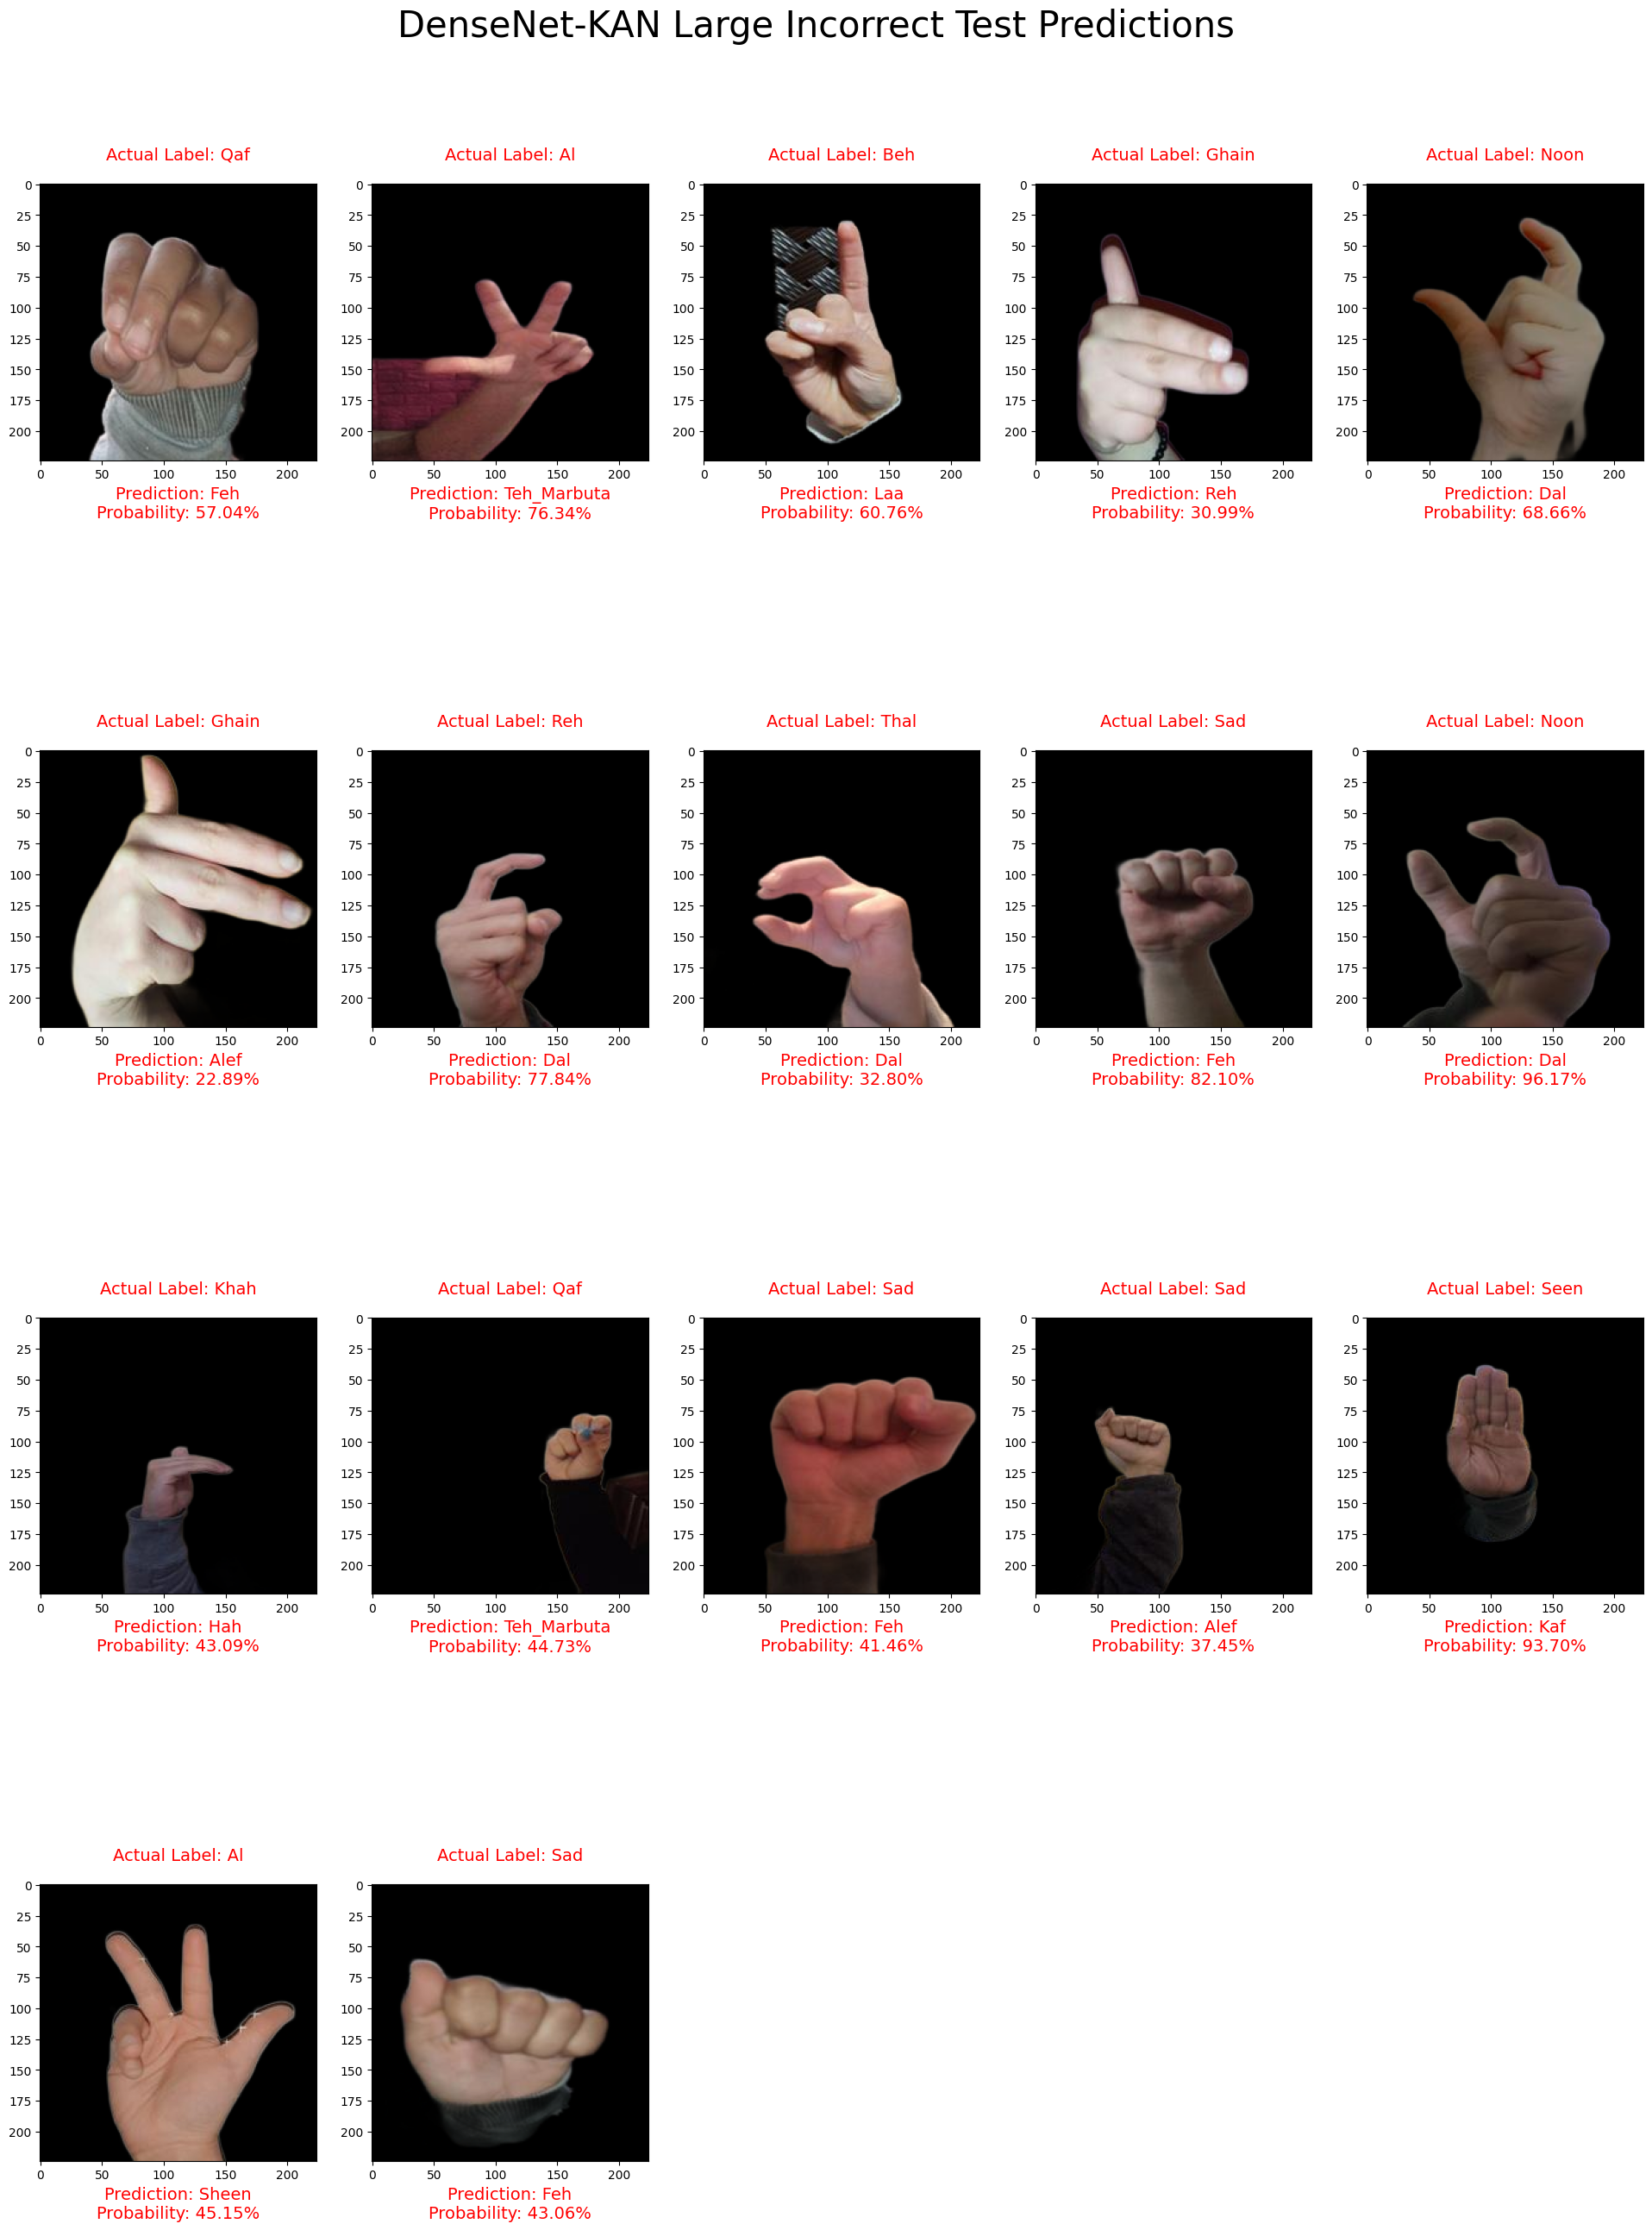

In [66]:
view_multiple_predictions(
    query_df,
    test_ds.classes,
    load, 
    count=17, 
    color_map='rgb', 
    title='DenseNet-KAN Large Incorrect Test Predictions',
    fig_size=(24, 30)
)

# **GradCAM**

In [45]:
#git clone
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-2k0eig75
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-2k0eig75
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit a2a23f83916d1caa428c447890d7ed5870818341
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39092 sha256=9c120d0d047d7cb84948cfaea76adb0271d4afc8bdeaef8794aad99400f86469
  Stored in directory: /tmp/pip-ephem-wheel-cache-swujoov4/wheels/23/11/66/71a38b0c29ba4ec5f62105a2145278613855bc9c94eecf630d
Successfully built grad-cam


In [46]:
#imports
import copy
import torchvision
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [47]:
target_layers = [model.model.features.denseblock4.denselayer16]

In [59]:
pd.set_option('display.max_colwidth', None)
sorted_df = results_df.sort_values(by="model_probability", ascending=False)
sorted_df.head(30)
#sorted_df['image_path']

image_path  \
313                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_125.jpg   
555                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_198.jpg   
520                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_178.jpg   
70                   /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_201.jpg   
102                   /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_92.jpg   
420                /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Zain/Zain_13.jpeg   
628                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_127.jpg   
329                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_215.jpg   
146                 /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_135.jpeg   
71                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_217.jpeg   
138                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_113.jpg   
560                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_114.jpg   
229                    /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_8.jpg   
552                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_155.jpg   
158                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_165.jpg   
510  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Teh_Marbuta/Teh_Marbuta_129.jpg   
489                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_214.jpg   
468  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Teh_Marbuta/Teh_Marbuta_64.jpeg   
59                   /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_153.jpg   
123   /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Teh_Marbuta/Teh_Marbuta_47.jpg   
321                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_228.jpg   
73   /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Teh_Marbuta/Teh_Marbuta_244.jpg   
311   /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Teh_Marbuta/Teh_Marbuta_84.jpg   
626  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Teh_Marbuta/Teh_Marbuta_252.jpg   
165  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Teh_Marbuta/Teh_Marbuta_207.jpg   
213               /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Zain/Zain_135.jpeg   
543                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Thal/thal_3.jpg   
503                  /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Feh/Feh_130.jpg   
78                   /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dad/Dad_258.jpg   
453                /kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Zain/Zain_27.jpeg   

           label  label_encoded  model_prediction  model_probability  
313          Dal              5                 5           0.990454  
555          Dal              5                 5           0.989585  
520          Dal              5                 5           0.989298  
70           Dal              5                 5           0.985747  
102          Dal              5                 5           0.984853  
420         Zain             30                30           0.984811  
628          Dal              5                 5           0.982699  
329          Dal              5                 5           0.982571  
146          Dal              5                 5           0.982563  
71           Dal              5                 5           0.981784  
138          Dal              5                 5           0.981168  
560          Dal              5                 5           0.979121  
229          Dal              5                 5           0.978793  
552          Dal              5                 5  

In [49]:
sorted_df.to_csv('DenseNet-KAN sorted probability.csv', index=True)

In [67]:
paths = "/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Heh/Heh_192.jpg"

rgb_img = Image.open(paths).convert('RGB')
# Max min normalization
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
# Create an input tensor image for your model
input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=input_tensor)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

**GradCAM Visualization**

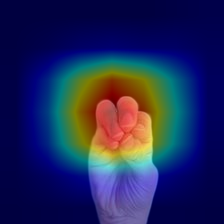

In [68]:
Image.fromarray(visualization, 'RGB')

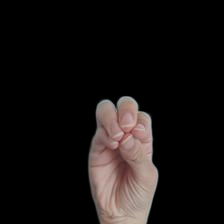

In [69]:
Image.open(paths).convert('RGB')